In [1]:
import tensorflow as tf
from datasets import load_dataset as ld
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd
import numpy as np

In [2]:
from datasets import load_dataset as ld

def load_dataset_as_pandas_dataframe(
    dataset_name: str="trec"
):

    dataset = ld(dataset_name)
    df = dataset["train"].to_pandas()
    df = df.sample(frac=1)

    df_test = dataset["test"].to_pandas()
    df_test = df_test.sample(frac=1)
    
    return df, df_test

In [3]:
df, df_test = load_dataset_as_pandas_dataframe()

In [4]:
df.head(5)

,text,coarse_label,fine_label
2679,How many pairs of wings does a tsetse fly have ?,5,38
3224,What does the theory of quantum leaps mean in ...,2,24
362,Which city did Christian Crusaders fight to re...,4,32
151,What athlete makes the most money from sports ...,3,29
3876,How long would it take to get from Earth to Ma...,5,44


- Processing Text Data

In [5]:
# Parameters 
vocab_size = 1000 
emebed_size = 20 
max_sequence_length = 14
epochs = 50
batch_size = 30 

In [6]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_test['text'])

## LSTM Text Classification Model


In [7]:
rnn_model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emebed_size,input_length = max_sequence_length), 
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(units=400,dropout=0.20),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(units=len(df.coarse_label.unique()), activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 20)            20000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 14, 20)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 400)               673600    
                                                                 
 layer_normalization (LayerN  (None, 400)              800       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 696,806
Trainable params: 696,806
Non-trai

In [9]:
test_sequences = tokenizer.texts_to_sequences(df_test['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [10]:
from sklearn.metrics import precision_recall_fscore_support

In [11]:
label_count = 0 
accs = [] 
precisions = [] 
recalls = [] 
f1s = []
labels = []

for i in range(15):
    label_count += 10
    labels.append(label_count)
    
    sequences = tokenizer.texts_to_sequences(df_test['text'][:label_count])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    rnn_model.fit(padded_sequences, df_test['coarse_label'][:label_count], epochs=50,validation_data=(test_padded_sequences, df_test['coarse_label']))
    
    predictions = rnn_model.predict(test_padded_sequences)
    predicted_labels = np.argmax(predictions, axis=1)
    
    
    precision, recall, f1, _ = precision_recall_fscore_support(df_test['coarse_label'], predicted_labels, average='macro',zero_division=1)

    
    accs.append(accuracy_score(df_test['coarse_label'],predicted_labels))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    



Epoch 1/50


1/1 [==============================] - 4s 4s/step - loss: 1.7956 - accuracy: 0.3000 - val_loss: 1.7008 - val_accuracy: 0.2760
Epoch 2/50
1/1 [==============================] - 0s 68ms/step - loss: 1.3521 - accuracy: 0.4000 - val_loss: 1.8901 - val_accuracy: 0.2760
Epoch 3/50
1/1 [==============================] - 0s 66ms/step - loss: 1.2302 - accuracy: 0.4000 - val_loss: 1.9982 - val_accuracy: 0.2940
Epoch 4/50
1/1 [==============================] - 0s 67ms/step - loss: 1.2780 - accuracy: 0.4000 - val_loss: 1.9973 - val_accuracy: 0.3860
Epoch 5/50
1/1 [==============================] - 0s 79ms/step - loss: 1.1023 - accuracy: 0.6000 - val_loss: 2.0388 - val_accuracy: 0.3600
Epoch 6/50
1/1 [==============================] - 0s 78ms/step - loss: 0.9392 - accuracy: 0.6000 - val_loss: 2.2639 - val_accuracy: 0.2960
Epoch 7/50
1/1 [==============================] - 0s 77ms/step - loss: 0.8901 - accuracy: 0.7000 - val_loss: 2.3355 - val_accuracy: 0.3340
Epoch 8/50
1/1 [========================

In [12]:
result_df = pd.DataFrame({'True_Label': df_test['coarse_label'], 'Predicted_Label': predicted_labels})

In [15]:
result_df.to_csv('evaluation/rnn_coarse_label_predictions.csv', index=False)


In [16]:
metrics_df = pd.DataFrame({
    'Label': labels,
    'Accuracy': accs,
    'Precision': precisions,
    'Recall': recalls,
    'F1': f1s
})

In [17]:
metrics_df.to_csv('evaluation/RNN_labels_metrics_result.csv', index=False)


In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


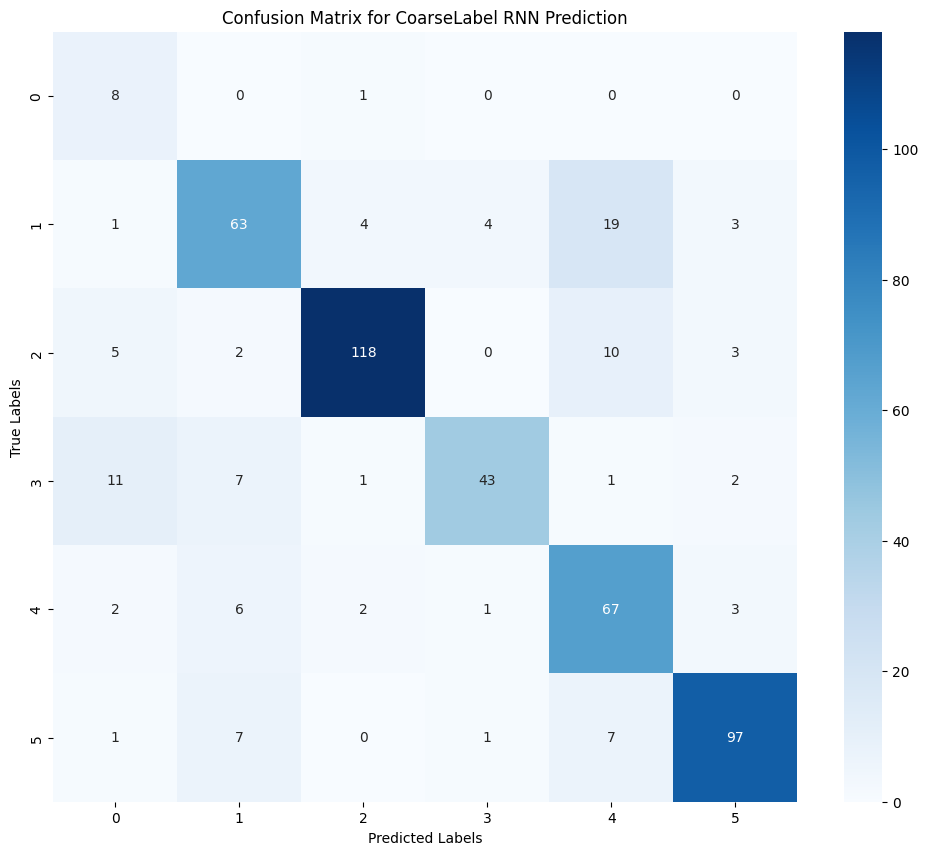

<Figure size 640x480 with 0 Axes>

In [23]:
# Compute the confusion matrix
cm = confusion_matrix(df_test['coarse_label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CoarseLabel RNN Prediction')
plt.show()
# Save the heatmap as an image in the 'evaluation' folder
plt.savefig('evaluation/Confusion_Matrix_Coarse_Label_RNN.png')